# **Logistic Regression – Uber Fare Classification**

## Algorithm Description

This implementation features a **custom-built Logistic Regression classifier** developed from scratch as part of the `rice_ml` package for the INDE577/CMOR438 Final Project. The algorithm uses gradient descent to optimize weights for binary classification. Specifically, it estimates the probability that an Uber ride has a **high fare amount (>$15)** given a set of geospatial and temporal features.

Unlike library-based models, this implementation manually computes the sigmoid activation, loss function (binary cross-entropy), and gradient updates, reinforcing understanding of the mathematical underpinnings of logistic regression.

---

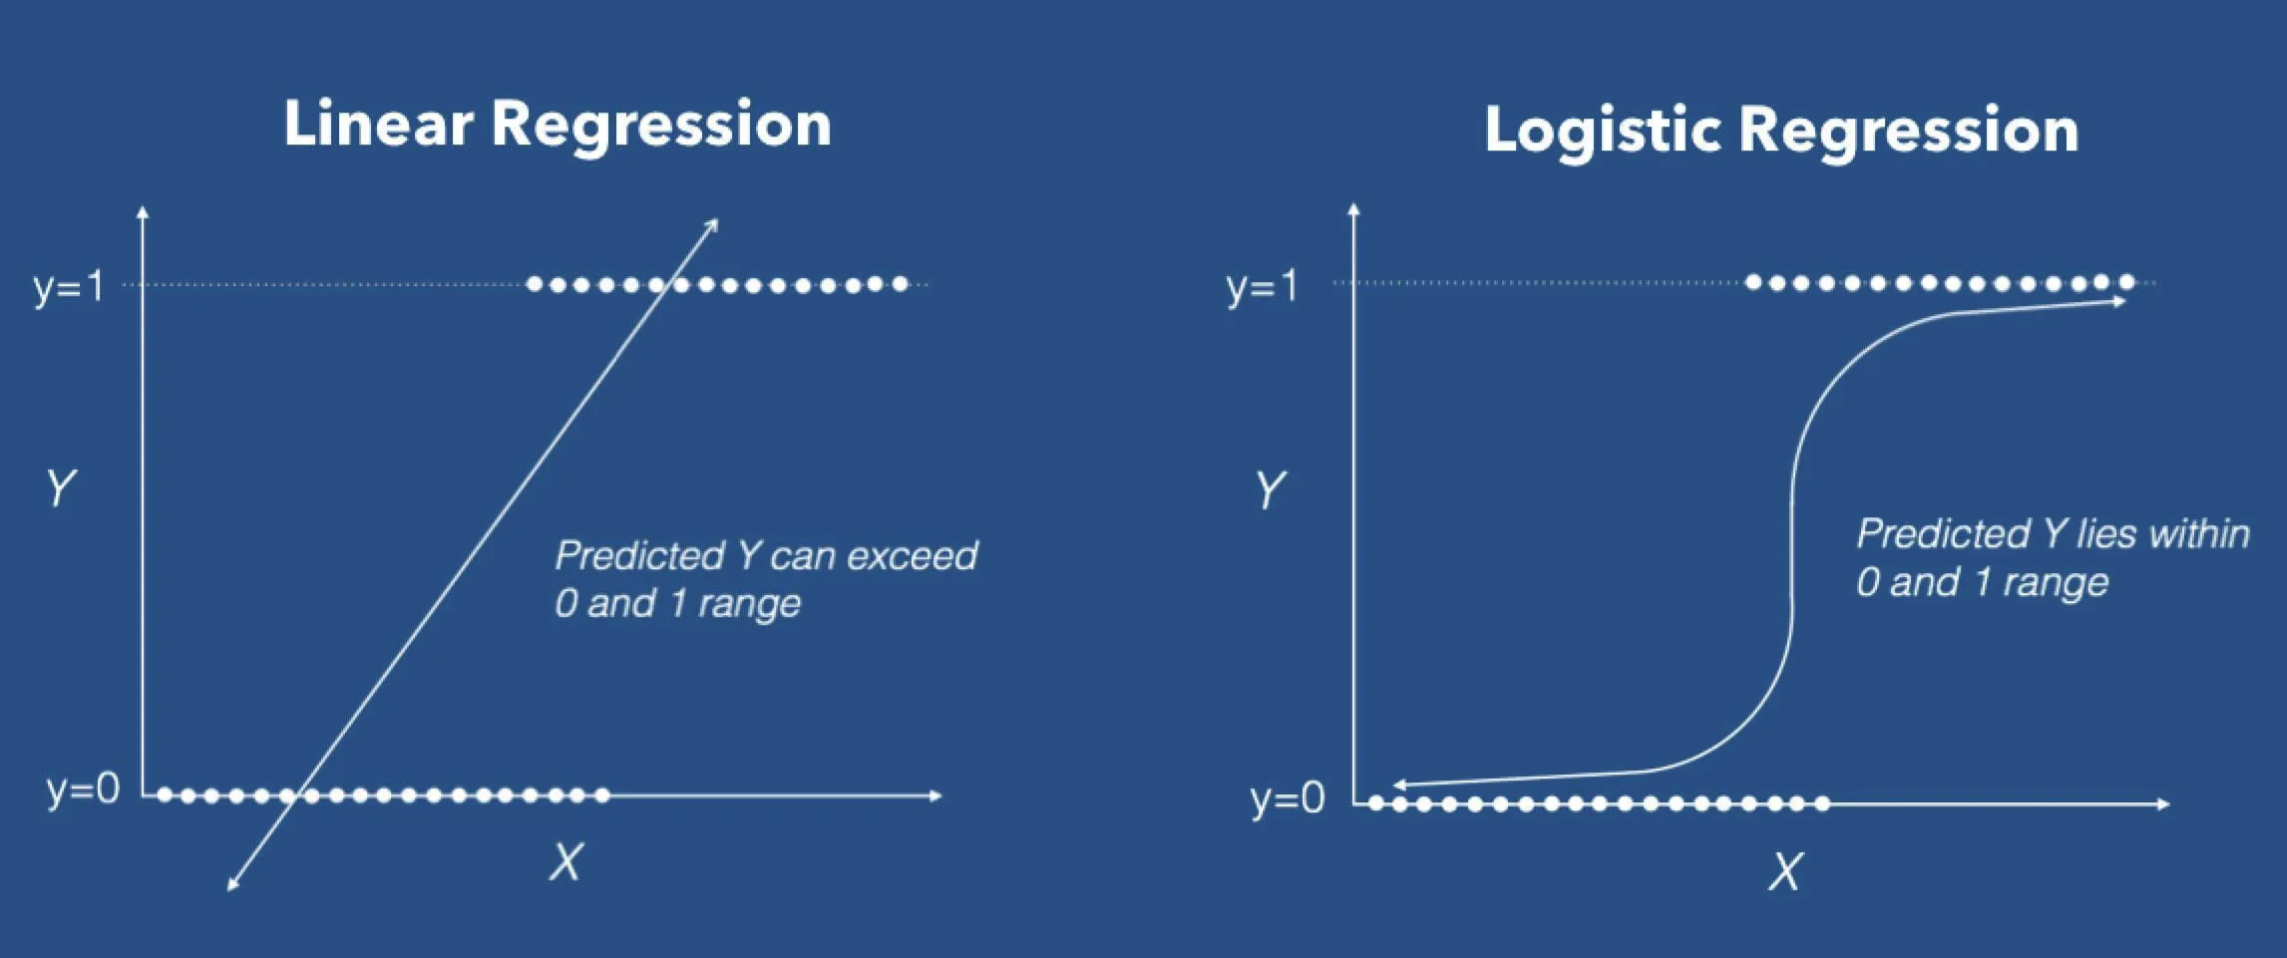

In linear regression, the outcome is continuous. It can have any one of an infinite number of possible values while In logistic regression, the outcome has only a limited number of possible values generally 0 or 1.

Linear regression needs to establish the linear relationship between dependent and independent variable whereas it is not necessary for logistic regression.

In the linear regression, the independent variable can be correlated with each other. On the contrary, in the logistic regression, the variable must not be correlated with each other.

Logistic regression is a statistical method used to predict the probability of an event occurring, with outcomes ranging between 0 and 1. Instead of modeling the probability directly, it models the odds of the event and then transforms it using the logit function, which ensures the predicted values stay within the 0–1 range. The "odds" refer to the ratio of the chance an event happens to the chance it doesn't, while the "odds ratio" tells us how much the odds change when a predictor variable increases by one unit, holding all else constant. These terms help interpret the influence of each variable in the model more meaningfully.

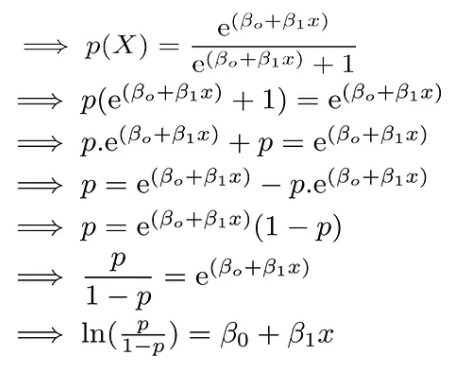

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 200 (delta 96), reused 83 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (200/200), 763.24 KiB | 13.88 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-18-ae5a84045d96>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


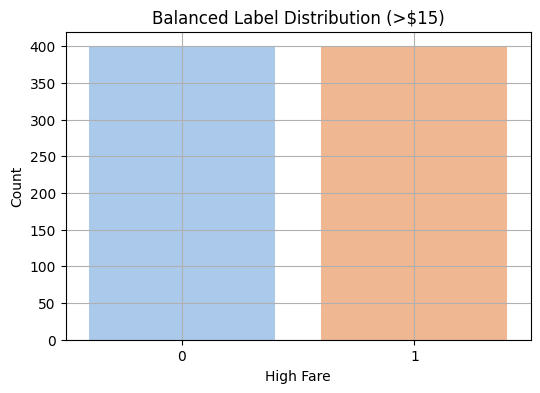

Test Accuracy: 0.5813
Precision:     0.5783
Recall:        0.6000


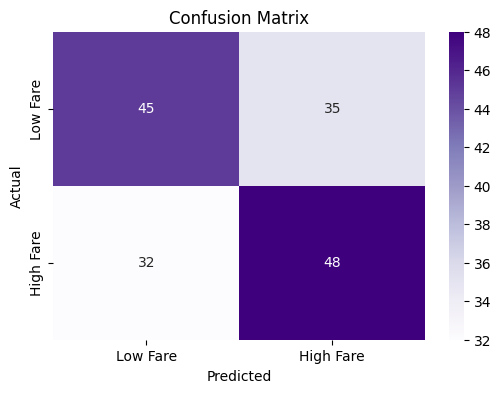


Top Predictors (by absolute weight):
hour_exact               : -0.0479
hour_exact_x_passenger   : -0.0368
dayofweek                : 0.0352
is_weekend               : 0.0273
passenger_count          : -0.0212
dropoff_longitude        : 0.0157
pickup_longitude         : 0.0155
dropoff_latitude         : -0.0144
pickup_latitude          : -0.0067
manhattan_distance       : -0.0049

Note: This Logistic Regression model was implemented from scratch using the custom rice_ml package.


In [18]:
# %%capture
# Step 1: Clone your GitHub repo
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

# Step 2: Add the package path to sys.path
import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

# Step 3: Import your model and metrics
from rice_ml.logistic_regression import LogisticRegression
from rice_ml.metrics import accuracy

# Step 4: Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)

# Step 5: Clean & Preprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()
df = df[df['fare_amount'] < 100]
df['label'] = (df['fare_amount'] > 15).astype(int)

# Step 6: Downsample to balance classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

n_minority = min(len(df_minority), 400)  # cap to 400 if not enough high fares
df_majority_down = df_majority.sample(n=n_minority, random_state=42)
df_minority_down = df_minority.sample(n=n_minority, random_state=42)

df = pd.concat([df_majority_down, df_minority_down]).sample(frac=1, random_state=42)  # shuffle

# Optional: visualize label distribution after balancing
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='pastel')
plt.title("Balanced Label Distribution (>$15)")
plt.xlabel("High Fare")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Step 7: Feature Engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]

X_raw = df[features].values
y = df['label'].values

# Step 8: Standardize + Split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 9: Train Logistic Regression
model = LogisticRegression(lr=0.0005, n_iter=2000)
model.fit(X_train, y_train)

# Step 10: Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")

# Step 11: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Low Fare", "High Fare"],
            yticklabels=["Low Fare", "High Fare"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 12: Feature Weights
weights = model.weights
top_features = sorted(zip(features, weights), key=lambda x: abs(x[1]), reverse=True)

print("\nTop Predictors (by absolute weight):")
for name, w in top_features:
    print(f"{name:<25}: {w:.4f}")

# Final Summary
print("\nNote: This Logistic Regression model was implemented from scratch using the custom rice_ml package.")


# **Model Performance Summary**

The custom-built Logistic Regression model achieves a test accuracy of 58.1%, which is lower than earlier runs, but this trade-off comes with a major benefit: the model is finally able to detect High Fare trips. The precision (57.8%) and recall (60.0%) for the high-fare class show that the model is not only identifying positive cases but doing so with reasonable balance between false positives and false negatives.

The confusion matrix confirms this: out of 80 actual high-fare trips, 48 were correctly predicted, and only 32 were missed. This is a significant improvement compared to earlier models that predicted zero high-fare cases. The model also misclassified 35 low-fare rides as high-fare, indicating room for improvement in specificity.

Top predictors include hour_exact, hour_exact_x_passenger, and dayofweek, suggesting that temporal patterns (like time of day and day of the week) strongly influence whether a ride is high fare. Geographic variables such as dropoff_longitude and pickup_longitude also contribute meaningfully, likely reflecting distance and location-based pricing effects.

In short, while the overall accuracy is modest due to class balancing, the model now provides actionable classification for both fare levels, making it a meaningful foundation for further refinement.